In [1]:
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
from datetime import datetime

style.use('fivethirtyeight')
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.3f}'.format
%matplotlib inline  

In [2]:
df_napic_master = pd.read_pickle('../data/interim/df_napic-14-3-2018')
df_napic_master["year_month"] = df_napic_master.TKH_NILAI.dt.to_period('M')

# Too many missing values
df_napic_master.drop('KLASIFIKASI_KAW', inplace=True, axis=1)
# for c in df_napic_master.columns:
#     if df_napic_master[c].dtype == 'object':
#         df_napic_master = df_napic_master[df_napic_master[c].notnull()].copy()
# filter out size using the same rule as BIS. Ref: https://www.bis.org/ifc/publ/ifcb44i.pdf
df_napic_master= df_napic_master[(df_napic_master['LUAS_LOT_BGN'] > 21) & (df_napic_master['LUAS_LOT_BGN'] < 10000)].copy()
df_napic_master= df_napic_master[(df_napic_master['LUAS_LOT'] > 21) & (df_napic_master['LUAS_LOT'] < 10000)].copy()

In [3]:
df_napic_master = df_napic_master[df_napic_master['year'] > 2012].copy()

In [4]:
df_napicKL = df_napic_master[df_napic_master['STATE'] == 'Kuala Lumpur'].copy()

In [5]:
df_napicKL['SKIM'].unique()

array(['JLN GAJUS', 'MIDAH RIA APARTMENT',
       'PKNS FLAT JLN KUCHING (TMN SRI DELIMA )', ...,
       'KG SEGAMBUT TENGAH', 'THE ENCLAVE', 'JALAN MAAROF'], dtype=object)

In [6]:
highrise_arr = ['Condominium/Apartment', 'Flats']
df_napicKL = df_napicKL[df_napicKL['PRO_TYPE'].isin(highrise_arr)].copy()
# df_napic_master['PRO_TYPE'].isin(highrise_arr)

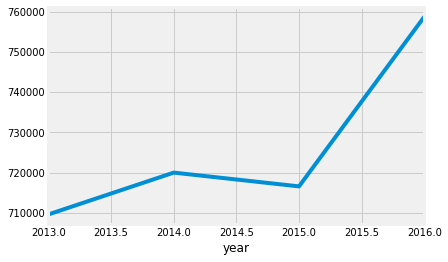

In [7]:
df_napicKL.groupby('year').mean()['HARGA_B'].plot()

# Breakdown by the cost of property listing. Obtain the threshold by comparing to income level / external sources

We found this on Housing Watch:

![Housing Affordability](../references/Max housing affordability.png)


Let's split into B40, M40, and U20. Based on this split, we can get an estimated price range of 'low-cost','middle-cost','high-cost' housing:

- Low : < RM 300 000
- Mid : RM 300 001 - 650 000
- High: RM >650 000

In [8]:
bins = [0, 300000, 650000, 1500000 ]
# bins= [0, 500000]
df_napicKL['price_bins'] =  np.searchsorted(bins, df_napicKL['HARGA_B'].values)

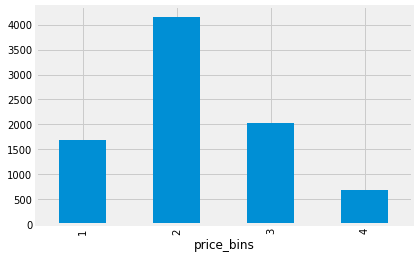

In [9]:
df_napicKL[df_napicKL['year'] == 2013].groupby('price_bins').count()\
                                        ['HARGA_B']\
                                        .plot(kind='bar')

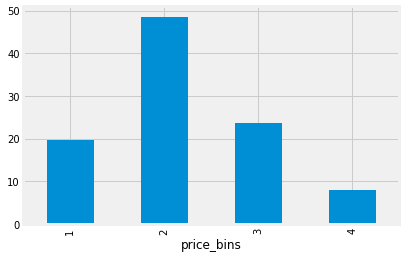

In [10]:
df_napicKL[df_napicKL['year'] == 2013].groupby('price_bins').count()\
                                        .apply(lambda x:100 * x / float(x.sum()))['HARGA_B']\
                                        .plot(kind='bar')

In [12]:
star_arr1 =pd.Series(
#                     data=[373665.66149756,  381721.45916423,  373873.99324472,
#         369325.66281681],
    data=[257369.55342668,  259384.15683814,  261243.6024524 ,
        261677.98018449],
                    index=df_napicKL[df_napicKL['price_bins'] == 2].groupby('year').mean()['HARGA_B'].index)
star_arr2 =pd.Series(
#                     data=[862948.97348998,  852482.67870702,  816132.20912109,
#         780419.06657817],
    data=[462524.73211851,  475190.15269759,  468154.94190996,
        460779.79933319],
                    index=df_napicKL[df_napicKL['price_bins'] == 2].groupby('year').mean()['HARGA_B'].index)
star_arr3 =pd.Series(
                    data=[868829.37285122,  884344.814523  ,  870208.05803661,
        872366.38876652],
                    index=df_napicKL[df_napicKL['price_bins'] == 2].groupby('year').mean()['HARGA_B'].index)

In [13]:
df_napicKL

ALAMAT  B_TINGKAT  \
1919905                      30-13-1,JLN MIDAH 8     20.000   
1921307           B-3-7,JALAN SULTAN ABDUL SAMAD     17.000   
1971727                       1-4-6,LORONG 2/125      5.000   
1974476              B-L-16 & B-L-17,JALAN 4/124     21.000   
1974491         B-L-11,B-L-12(B-B-2),JALAN 4/124     21.000   
1984641                    2-7-11,JLN SRI JATI 3     18.000   
1984679                         2-5-11,JLN 3/124     23.000   
1984707                     200-2-5,JLN SG. BESI      5.000   
1984714                          1-3-5,JLN 6/38A     23.000   
1987040                        B-05-6,JLN 3/149E     20.000   
1988617                         2-2-17,JLN 3/124     23.000   
1989261                          2-5-4,JLN 3/124     23.000   
1990419                        42-12B,JALAN ALOR     17.000   
1990446                        B-3-8,JLN PRIMA 3     15.000   
1993882                          1-8-8,JLN 4/89A     19.000   
1996769                        5-5-13,JALAN 2/40      6.000   
1996842                    2-6-11,JLN SRI JATI 3     18.000   
1996852                       2-8-5,JLN KERINCHI     15.000   
1996855                        18-6-13,JLN 19/32     14.000   
2001277           12-12-7 (P: C-12-4),JLN 1C/149     14.000   
2001621                          1-3-5,JLN 6/38A     23.000   
2002117                  81-03-26,OFF JLN SENTUL      5.000   
2003210                   2-15-13,JLN SRI JATI 3     18.000   
2004820                        5-1-29,JALAN 2/40      6.000   
2008233                     2-5-6,JLN SRI JATI 3     18.000   
2008261                     C-13-13,JALAN 30/146     19.000   
2008291                    1-3-16,OFF JLN KEPONG      6.000   
2010890  82-07-09,JLN 2/116B, OF JLN KUCHAI LAMA     18.000   
2011772                      B-14-10,JLN PRIMA 3     15.000   
2013370                      28-1-4,JALAN GOMBAK     19.000   
...                                          ...        ...   
2965597                30-21-3,JLN BULUH PERINDU     24.000   
2965601                   A-23-3A,JALAN MENERUNG     28.000   
2965605                        9-01,JALAN STONOR     40.000   
2965615                    A-12-1,JALAN MENERUNG      4.000   
2965654                 A-23-3A,JLN BUKIT PANTAI     25.000   
2965655                       A4-3,JLN TUN RAZAK     16.000   
2965656                        01-04,JLN U-THANT      3.000   
2965672                        32-1,JALAN STONOR     40.000   
2965673                        30-1,JALAN STONOR     40.000   
2965680                        17-1,JALAN STONOR     40.000   
2965681                        17-1,JALAN STONOR     40.000   
2965687                A-19-2,JALAN SRI HARTAMAS     20.000   
2965688                  A-03A-01,JALAN KIA PENG      5.000   
2965690                    A-25-1,JALAN MENERUNG     23.000   
2965692                   A-21-02,JALAN MENERUNG      4.000   
2965702                        35-1,JALAN STONOR     40.000   
2965705                   B-01-01,JALAN KIA PENG      5.000   
2965712               B-19-01,JALAN SRI HARTAMAS     20.000   
2965722                       32-3A,JALAN STONOR     40.000   
2965723               A-40-2,CHANGKAT DUTA KIARA     12.000   
2965733                      41-02,JALAN CENDANA     43.000   
2965755                    C-01-1,JALAN MENERUNG     23.000   
2965768               D-11-3,CHANGKAT DUTA KIARA     12.000   
2965776               B-40-2,CHANGKAT DUTA KIARA     12.000   
2965790                         9-A,JALAN PINANG     35.000   
2965804           B-16-2,NO.98, JLN MEDANG SERAI     30.000   
2965822                     A-3-2,JALAN KIA PENG      5.000   
2965837         BT-12-1, NO. 16, PERSIARAN KLCC,     45.000   
2965841                   D-19-02,JALAN MENERUNG     23.000   
2965858    PRIMA HARMONI,PERSIARAN PRIMA PELANGI      4.000   

                          DAERAH1  HARGA_B                 JENIS_HAKMILIK  \
1919905        Mukim Kuala Lumpur     9000  Geran Mukim Pe

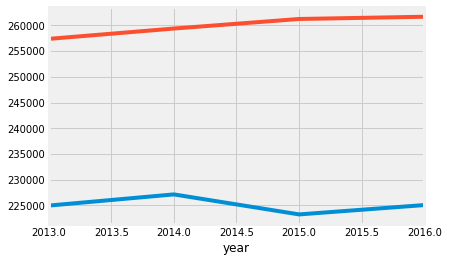

In [14]:
df_napicKL[df_napicKL['price_bins'] == 1].groupby('year').mean()['HARGA_B'].plot()
star_arr1.plot()

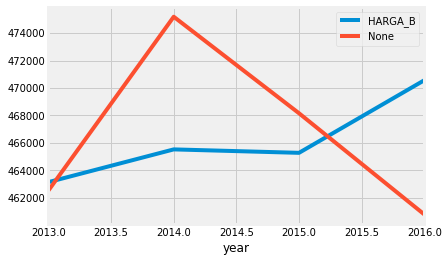

In [15]:
df_napicKL[df_napicKL['price_bins'] == 2].groupby('year').mean()['HARGA_B'].plot()
star_arr2.plot()
plt.legend()

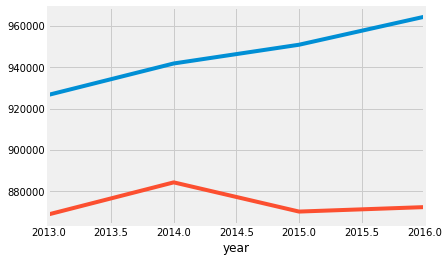

In [16]:
df_napicKL[df_napicKL['price_bins'] == 3].groupby('year').mean()['HARGA_B'].plot()
star_arr3.plot()

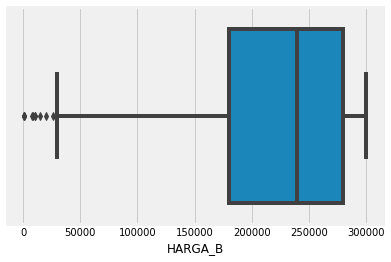

In [17]:
sns.boxplot(df_napicKL[df_napicKL['price_bins'] == 1]['HARGA_B'])

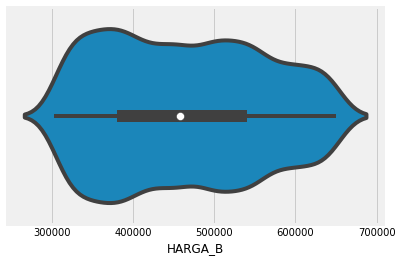

In [20]:
sns.violinplot(df_napicKL[(df_napicKL['price_bins'] == 2) &
                         (df_napicKL['year'] == 2013)]['HARGA_B'])

In [19]:
df_napicKL.describe()

B_TINGKAT        HARGA_B   LUAS_LOT  LUAS_LOT_BGN  STAT_FEREE  \
count 22,286.000     22,286.000 22,286.000    22,286.000  22,286.000   
mean      20.553    720,248.429    130.467       128.967       2.273   
std        9.167    821,756.187    123.760       101.235       1.404   
min        0.000      1,000.000     22.000        22.000       1.000   
25%       15.000    360,000.000     92.000        92.000       2.000   
50%       20.000    518,000.000    112.000       112.000       2.000   
75%       26.000    781,500.000    138.000       138.000       2.000   
max       47.000 35,500,000.000  9,253.000     9,976.000      11.000   

       STAT_FEROR      SYER1      SYER2       year      month        day  \
count  22,286.000 22,286.000 22,286.000 22,286.000 22,286.000 22,286.000   
mean        2.846      1.000      1.015  2,014.078      6.614     16.246   
std         1.754      0.019      0.316      1.047      3.405      8.807   
min         1.000      1.000      1.000  2,013.000      1.000      1.000   
25%         2.000      1.000      1.000  2,013.000      4.000      8.000   
50%         2.000      1.000      1.000  2,014.000      7.000     17.000   
75%         4.000      1.000      1.000  2,015.000     10.000     24.000   
max        11.000      2.000     40.000  2,016.000     12.000     31.000   

         quarter  Price_per_sqrft  Price_per_sqrft_lot  Price_per_sqrft_min  \
count 22,286.000       22,286.000           22,286.000           22,286.000   
mean       2.535        5,068.008            5,064.327            5,043.828   
std        1.106        2,303.913            2,333.849            2,268.372   
min        1.000            8.696                8.703                8.696   
25%        2.000        3,733.333            3,728.814            3,725.490   
50%        3.000        4,637.681            4,637.931            4,625.000   
75%        4.000        6,000.000            6,000.000            5,982.143   
max        4.000      105,820.106          105,820.106          105,820.106   

       price_bins  
count  22,286.000  
mean        2.256  
std         0.828  
min         1.000  
25%         2.000  
50%         2.000  
75%         3.000  
max         4.000

In [5]:
df_napic_master[df_napic_master['PM_PERTAMA'] == 'Y']['TRANSEFEROR'].value_counts()

MUTIARA RINI SDN BHD                             1765
SCIENTEX QUATARI SDN BHD                         1644
PROPERTY SKYLINE SDN BHD                         1523
EUPE KEMAJUAN SDN BHD                            1394
OSK PROPERTIES SDN BHD                           1309
KELADI HARTA SDN BHD                             1257
PKNS                                             1206
BANDAR SETIA ALAM SDN BHD                        1182
SYARIKAT PERUMAHAN NEGARA BERHAD                 1107
KOPERASI KEMAJUAN TANAH NEGERI JOHOR BERHAD      1099
JOHOR LAND BERHAD                                1097
PERBADANAN KEMAJUAN NEGERI SELANGOR              1094
NUSAJAYA GREENS SDN BHD                          1077
ZAMAN TELADAN SDN BHD                            1069
AGRO-MOD INDUSTRIES SDN BHD                      1005
BERTAM PROPERTIES SDN BHD                         930
GJH CONSTRUCTION SDN BHD                          920
NUSAJAYA HEIGHTS SDN BHD                          907
AMBANGAN HEIGHTS SDN BHD    

In [6]:
df_napic_master[df_napic_master['PM_PERTAMA'] == 'T']['TRANSEFEROR'].value_counts()

PERBADANAN KEMAJUAN NEGERI SELANGOR              1742
PUBLIC BANK BERHAD                               1125
DBKL                                              894
DATUK BANDAR KUALA LUMPUR                         707
CIMB BANK BERHAD                                  632
MAXISEGAR SDN BHD                                 625
HOUSING DEVELOPMENT CORPORATION                   603
MALAYAN BANKING BERHAD                            601
PERBADANAN MENTERI BESAR KELANTAN                 594
LEMBAGA TABUNG AMANAH WARISAN NEGERI TERENGGA     524
BANDAR SETIA ALAM SDN BHD                         518
NARAJAYA SDN BHD                                  482
AMBANK (M) BERHAD                                 477
RAJU A/L PUNNASAMY                                431
PKNS                                              426
AGENDA ISTIMEWA SDN BHD                           374
RHB BANK BERHAD                                   348
MALAYSIA BUILDING SOCIETY BERHAD                  335
MIRI HOUSING DEVELOPMENT REA

In [7]:
df_possibleprimary = df_napic_master[df_napic_master['PM_PERTAMA'] == 'Y'].copy()

In [8]:
df_possibleprimary

ALAMAT  B_TINGKAT      DAERAH1  \
977697                                M2/4/172,      5.000  Johor Bahru   
977760                  12-03-07,BLOK TEMENGONG      5.000    Kulaijaya   
978474   03-53-BLOK F,JLN PERSIARAN DESA RAKYAT      5.000  Johor Bahru   
978488                      M5-4,JALAN PULAI 84      5.000  Johor Bahru   
978524              M2/3/89,JLN PULAI HARMONI 3      4.000  Johor Bahru   
978533             A3-02-17,JLN PULAI HSRMONI 1      5.000  Johor Bahru   
978534                         BLOK 18-01-0201,      4.000  Johor Bahru   
978541              M2/3/88,JLN PULAI HARMONI 3      4.000  Johor Bahru   
978576                          21,JLN DANAU 47      2.000  Johor Bahru   
978609                     21-02-01-32,BLOCK 24      5.000  Johor Bahru   
978632      BLK D 02-09,JLN PERSIARAN CEMERLANG      5.000  Johor Bahru   
978770                BLOK G,03-02,JLN PEKAKA 3      4.000  Johor Bahru   
978865                         27,JLN JURAGAN 1      2.000  Johor Bahru   
978898                   F-08-02,JALAN CANTIK 7      5.000  Johor Bahru   
978902                          TAMAN KOTA AMAN      2.000   Batu Pahat   
978935             M4/3/188,JLN SRI PERKASA 1/1      5.000  Johor Bahru   
978964                   G-03-06,JALAN PULAI 84      5.000  Johor Bahru   
978966                   VF-03-01,BAYU PUTERI 2     13.000  Johor Bahru   
978967                      04-04,BLOK GEHARU B      5.000  Johor Bahru   
979070                      P-3-01,JLN TASEK 64      5.000  Johor Bahru   
979071         BLOK E-2-3,JALAN SRI PERKASA 1/1      5.000  Johor Bahru   
979078              BLOK 3 #06-09,JALAN SETIA 4      5.000  Johor Bahru   
979082                       C-3-11,JLN PUTRA 3      4.000  Johor Bahru   
979095          J-02-06,RUMAH PANGSA KOS RENDAH      5.000  Johor Bahru   
979096                     Q-05-09,JLN BALAU 17      5.000  Johor Bahru   
979104                      37,JLN KOTA AMAN 12      2.000   Batu Pahat   
979118                   C-05-03,JALAN CANTIK 7      5.000  Johor Bahru   
979138                     G-01-04,JLN PULAI 84      5.000  Johor Bahru   
979139                                B2-02-17,      5.000  Johor Bahru   
979140               BLOK B-T2-25,BLOK B, TKT 2      5.000  Johor Bahru   
...                                         ...        ...          ...   
3147232                            PT 13430,P8E      3.000    Putrajaya   
3147236                            PT 13435,P8E      3.000    Putrajaya   
3147237                            PT 13418,P8E      3.000    Putrajaya   
3147238                             P 13419,P8E      3.000    Putrajaya   
3147239                         NO 59,JALAN P8G      2.000    Putrajaya   
3147240                            PT 13434,P8E      3.000    Putrajaya   
3147241                         NO.24,JALAN P8G      3.000    Putrajaya   
3147242                            PT 13440,P8E      3.000    Putrajaya   
3147245                            PT 13442,P8E      3.000    Putrajaya   
3147247                           PRESINT 8,P8E      3.000    Putrajaya   
3147248                               13447,P8E      3.000    Putrajaya   
3147249                        PT13429,JLN P18G      3.000    Putrajaya   
3147250                         NO.50,JALAN P8G      3.000    Putrajaya   
3147251                           RB9,JALAN P16      2.000    Putrajaya   
3147254                            PT 13401,P8E      3.000    Putrajaya   
3147255                  13428,JALAN P8G (FERA)      3.000    Putrajaya   
3147256                         NO 27,JALAN P8G      3.000    Putrajaya   
3147264                          NO.42,JALAN P8      3.000    Putrajaya   
3147265                       PT13404,JALAN P8G      3.000    Putrajaya   
3147266                          NO.33,JALAN P8      3.000    Putrajaya   
3147267                          NO.38,JALAN P8      3.000    Putrajaya   
3147268                          NO 29,JALAN P8      3.000    Putr

In [9]:
df_possibleprimary['JENIS_LOT'].value_counts()

P.T.                 158655
Hakmilik Muktamad     48333
Strata                21524
No. Pemaju             2639
Lain-Lain              1532
No. Jabatan             149
Name: JENIS_LOT, dtype: int64

In [10]:
df_possibleprimary['PRO_TYPE'].value_counts()

2 - 2 1/2 Storey Terraced         80721
1 - 1 1/2 Storey Terraced         64437
1 - 1 1/2 Storey Semi-Detached    22558
2 - 2 1/2 Storey Semi-Detached    19349
Condominium/Apartment             12982
Low-Cost House                     9100
Detached                           8796
Cluster House                      5340
Low-Cost Flat                      4703
Flat                               4169
Town House                          708
Others                               29
Name: PRO_TYPE, dtype: int64

In [11]:
df_possibleprimary[df_possibleprimary['JENIS_LOT'] =='Strata']

ALAMAT  B_TINGKAT  \
977697                                           M2/4/172,      5.000   
977760                             12-03-07,BLOK TEMENGONG      5.000   
978474              03-53-BLOK F,JLN PERSIARAN DESA RAKYAT      5.000   
978488                                 M5-4,JALAN PULAI 84      5.000   
978524                         M2/3/89,JLN PULAI HARMONI 3      4.000   
978533                        A3-02-17,JLN PULAI HSRMONI 1      5.000   
978534                                    BLOK 18-01-0201,      4.000   
978541                         M2/3/88,JLN PULAI HARMONI 3      4.000   
978609                                21-02-01-32,BLOCK 24      5.000   
978632                 BLK D 02-09,JLN PERSIARAN CEMERLANG      5.000   
978770                           BLOK G,03-02,JLN PEKAKA 3      4.000   
978898                              F-08-02,JALAN CANTIK 7      5.000   
978935                        M4/3/188,JLN SRI PERKASA 1/1      5.000   
978964                              G-03-06,JALAN PULAI 84      5.000   
978966                              VF-03-01,BAYU PUTERI 2     13.000   
978967                                 04-04,BLOK GEHARU B      5.000   
979070                                 P-3-01,JLN TASEK 64      5.000   
979071                    BLOK E-2-3,JALAN SRI PERKASA 1/1      5.000   
979078                         BLOK 3 #06-09,JALAN SETIA 4      5.000   
979082                                  C-3-11,JLN PUTRA 3      4.000   
979095                     J-02-06,RUMAH PANGSA KOS RENDAH      5.000   
979096                                Q-05-09,JLN BALAU 17      5.000   
979118                              C-05-03,JALAN CANTIK 7      5.000   
979138                                G-01-04,JLN PULAI 84      5.000   
979139                                           B2-02-17,      5.000   
979140                          BLOK B-T2-25,BLOK B, TKT 2      5.000   
979959                                            7-02-28,      1.000   
980209                        RUMAH PANGSA TMN FLORA UTAMA      3.000   
980307                                   I-3-16,JLN EJ 8/2      5.000   
980319                              D-02-12,RIA  APARTMENT      5.000   
...                                                    ...        ...   
3134277                                           9,DU 5/1      2.000   
3134568                                      33,JLN DU 5/6      2.000   
3134682                                     7,JALAN DU 5/1      2.000   
3134690                                       1,JLN DU 5/2      2.000   
3134788                                       3,JLN DU 5/1      2.000   
3134818                          13A,JALAN BAYU KEMENSAH 1      2.000   
3134831                     ZG-G/01/02/03-5,JLN KINRARA 6B     20.000   
3134900                                    18,JLN PJU 3/51      2.000   
3134953                                    25,JLN PJU 3/51      2.000   
3135009                          NO. 26,JALAN GR 6/1 ASPEN      4.000   
3135082                       30,THE VILLA @ SERAI SAUJANA      3.000   
3135187                                      12,JLN DU 6/5      3.000   
3135215                                       5,JLN DU 6/5      2.000   
3135217                                    11,JLN PJU 3/51      2.000   
3135252               L78,JLN PJU 3/51, SUNWAY RIMBA HILLS      2.000   
3135266                       NO.9,JALAN DU 6/4 (AMBROSIA)      3.000   
3135270                      10,THTE VILLA @ SERAI SAUJANA      2.000   
3135378                                  28,PERSIARAN GOLF      1.000   
3135402                                 25,LORONG SS 23/6G      4.000   
3135459               L45,JLN PJU 3/51, SUNWAY RIMBA HILLS      2.000   
3135516                                    50,JLN PJU 3/51      2.000   
3136115                              5,JALAN DAHLIA,PJU 6A      3.000   
3138157                     FLAT DUSUN NYIOR,OFF JLN JAKAR      4.000   
3146974                              

In [12]:
df_possibleprimary = df_possibleprimary[(df_possibleprimary['STATE'] == 'Kuala Lumpur') ].copy()
df_possibleprimary = df_possibleprimary[(df_possibleprimary['PRO_TYPE'] == 'Condominium/Apartment')].copy()

In [13]:
df_possibleprimary

ALAMAT  B_TINGKAT  \
1032825                         E-09-07,JLN KELANG LAMA     15.000   
1033255                     F-8-1(PCL B-8-1),JLN 2/109C     12.000   
1033804                    F-7-14(P: B-7-14),JLN 2/109C     12.000   
1034076                              2-13-10,JLN 10/21D     15.000   
1034380                          10E-04-05-01,JLN 4/27E      4.000   
1034641                              4843,JALAN PERKASA      6.000   
1034646                 28-17-3 (P: E-1502),JALAN 1/91B     24.000   
1034756                             82-16-13,JLN 2/116B     18.000   
1034775                      50-6-3 (N2-6-10),JLN 8/38A      7.000   
1034840                            81-207,JLN AIR PANAS      7.000   
1034866                            C-21-12,JALAN 13/21D     21.000   
1034867                             C-27-6,JALAN 13/21D     21.000   
1034886                                C-2-2,JLN 2/109C     12.000   
1034995                   A-10-3 (M1-10-145),JLN 2/109C     12.000   
1035220             32-14-1(PCL G-12-4),JLN CHERAS LAMA     21.000   
1035429                              32-03-03,JLN 8/113      5.000   
1035430               C-13-11(P: E3-13-11),JLN MIDAH 8A     15.000   
1035474                               2-8-18,JLN 10/21D     15.000   
1035494             C-10-10(P: E3-10-10),JALAN MIDAH 8A     15.000   
1035789             32-15-5 (G-13-8),JLN PANDAN PERDANA     21.000   
1035894                       C-8-8,JLN TMN SRI SENTOSA     15.000   
1036186                   A-9-5(P: A-10-12),JLN 18/144A     11.000   
1036188              30-10-3(PCL F-8-2),JLN CHERAS LAMA     21.000   
1036194                     A-7-5(PCL H-8-08),JLN 1/91B     28.000   
1036204                     C-17-2,JLN SRI PERMAISURI 3     12.000   
1036284                             82-02-19,JLN 2/116B     18.000   
1036294                    B-09-19,JLN SRI PERMAISURI 3     12.000   
1036305                10-12 (P: C-10-3A),JALAN MIDAH 8     17.000   
1036314                    200-12-7,JLN. KG. BDR. DALAM     21.000   
1036343                     200-7-5,JLN. KG. BDR. DALAM     21.000   
...                                                 ...        ...   
2965053                       B-20-3,JALAN BUKIT PANTAI     29.000   
2965079                            C-29-6,JALAN KIARA 3     41.000   
2965112                           C-23A-5,JALAN KIARA 3     41.000   
2965121                       A23 & 24-3A,JALAN KIARA 3     25.000   
2965133                           B-12A-02,JALAN CEYLON     43.000   
2965171                            C-35-5,JALAN KIARA 3     41.000   
2965186                      A-31-6,CHANGKAT DUTA KIARA     32.000   
2965191                    B-10-03,JALAN SRI HARTAMAS 1     24.000   
2965220                      B-10-6,CHANGKAT DUTA KIARA     32.000   
2965228                         B-03A-01,JALAN KIA PENG      5.000   
2965272           18-B,LORONG KUDA, OFF JALAN TUN RAZAK     41.000   
2965273                      A-22-6,CHANGKAT DUTA KIARA     32.000   
2965278                           D-33A-2,JALAN KIARA 1     42.000   
2965300                       D-G-5,CHANGKAT DUTA KIARA     32.000   
2965422                            B-22-02,JALAN CEYLON     43.000   
2965501                BT-11-3, NO. 16, PERSIARAN KLCC,     45.000   
2965533               BT-21-03, NO. 16, PERSIARAN KLCC,     45.000   
2965534                             A-5-2,JALAN KIARA 1     42.000   
2965540                BT-22-3, NO. 16, PERSIARAN KLCC,     45.000   
2965548                BT-10-2, NO. 16, PERSIARAN KLCC,     45.000   
2965565                               10-2,JALAN STONOR     40.000   
2965655                              A4-3,JLN TUN RAZAK     16.000   
2965681                               17-1,JALAN STONOR     40.000   
2965688                         A-03A-01,JALAN KIA PENG      5.000   
2965705                          B-01-01,JALAN KIA PENG      5.000   
2965712                      B-19-01,JALAN SRI HARTAMAS    

In [14]:
columns_of_interest = ['HARGA_B', 'LUAS_LOT_BGN', 'Price_per_sqrft']
df_possibleprimary_tst = df_possibleprimary.groupby('year_month')[columns_of_interest].agg(['mean', 'median','count'])

In [15]:
df_secondaryprimary = df_napic_master[df_napic_master['PM_PERTAMA'] == 'T'].copy()
df_secondaryprimary = df_secondaryprimary[(df_secondaryprimary['STATE'] == 'Kuala Lumpur') ].copy()
df_secondaryprimary = df_secondaryprimary[(df_secondaryprimary['PRO_TYPE'] == 'Condominium/Apartment') ].copy()

In [16]:
columns_of_interest = ['HARGA_B', 'LUAS_LOT_BGN', 'Price_per_sqrft']
df_secondaryprimaryy_tst = df_secondaryprimary.groupby('year_month')[columns_of_interest].agg(['mean','median', 'count'])

In [17]:
df_secondaryprimaryy_tst

HARGA_B               LUAS_LOT_BGN                \
                  mean  median count         mean  median count   
year_month                                                        
2010-01    415,029.587  245000   407      117.113 105.000   407   
2010-02    402,452.728  273000   382      117.945 107.000   382   
2010-03    419,596.968  265000   555      119.985 110.000   555   
2010-04    461,560.735  270000   573      122.216 111.000   573   
2010-05    442,387.997  288000   624      121.634 112.000   624   
2010-06    449,064.568  278000   681      119.916 109.000   681   
2010-07    377,555.433  275000   660      116.609 111.000   660   
2010-08    442,905.047  268000   661      119.138 107.000   661   
2010-09    411,913.727  290000   735      117.500 111.000   735   
2010-10    430,082.810  275000   663      120.285 110.000   663   
2010-11    384,567.119  270000   554      115.013 106.000   554   
2010-12    401,764.248  250000   689      114.959 104.000   689   
2011-01    484,126.882  300000   619      120.075 105.000   619   
2011-02    449,111.369  290000   423      114.421 106.000   423   
2011-03    504,872.464  328000   689      120.179 107.000   689   
2011-04    492,465.051  300000   668      119.774 106.000   668   
2011-05    518,728.668  332500   780      124.929 110.000   780   
2011-06    474,176.479  325000   749      116.415 107.000   749   
2011-07    483,416.007  305000   719      118.466 105.000   719   
2011-08    534,850.144  342000   651      123.659 107.000   651   
2011-09    475,430.655  313000   629      116.301 105.000   629   
2011-10    528,916.126  340000   636      123.604 109.000   636   
2011-11    526,619.090  336000   667      121.644 107.000   667   
2011-12    496,693.651  347500   716      118.198 106.000   716   
2012-01    509,789.295  370000   390      122.213 109.000   390   
2012-02    513,756.049  373500   548      116.874 105.500   548   
2012-03    529,624.618  375000   634      119.278 106.000   634   
2012-04    518,080.989  381500   534      118.806 107.000   534   
2012-05    678,644.343  395000   724      127.318 106.000   724   
2012-06    508,254.123  365000   600      118.331 106.000   600   
...                ...     ...   ...          ...     ...   ...   
2014-07    672,926.994  508000   493      125.266 112.000   493   
2014-08    753,358.820  550000   577      134.779 113.000   577   
2014-09    625,478.553  530000   465      119.337 112.000   465   
2014-10    650,820.683  508000   656      121.526 111.000   656   
2014-11    690,712.095  530000   516      120.384 108.775   516   
2014-12    676,414.159  530000   498      123.959 112.000   498   
2015-01    690,508.013  520000   395      122.741 107.000   395   
2015-02    733,039.392  560000   347      128.220 112.870   347   
2015-03    672,084.000  516500   398      122.206 108.000   398   
2015-04    673,090.529  532500   348      120.001 107.000   348   
2015-05    750,495.987  550000   378      129.338 113.000   378   
2015-06    703,056.389  526000   406      125.952 111.000   406   
2015-07    717,942.915  555000   410      123.741 110.000   410   
2015-08    664,259.056  525000   360      120.086 110.500   360   
2015-09    717,200.475  520000   375      121.820 106.000   375   
2015-10    678,859.610  520000   362      122.735 109.530   362   
2015-11    735,885.333  501000   336      125.860 105.000   336   
2015-12    724,937.151  530000   345      125.050 110.150   345   
2016-01    741,509.681  563000   313      126.731 112.870   313   
2016-02    689,723.678  500000   236      123.632 108.570   236   
2016-03    738,906.762  540000   277      129.032 111.680   277   
2016-04    726,015.130  550000   262      124.989 110.500   262   
2016-05    754,467.519  569000   318      131.077 118.000   318   
2016-06    733,255.463  520000   281      123.943 105.000   281   
2016-07    734,854.112  562500   224      127.475 114.000   224   
2016-08    778,917.542  590000   240      135.955 115.410   24

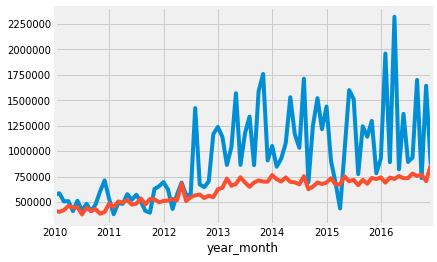

In [18]:
df_possibleprimary_tst['HARGA_B']['mean'].plot()
df_secondaryprimaryy_tst['HARGA_B']['mean'].plot()

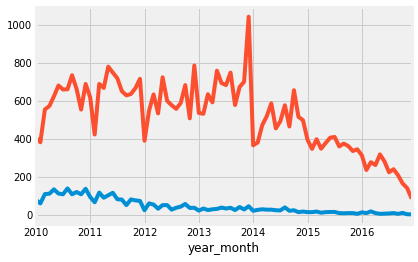

In [19]:
df_possibleprimary_tst['HARGA_B']['count'].plot()
df_secondaryprimaryy_tst['HARGA_B']['count'].plot()

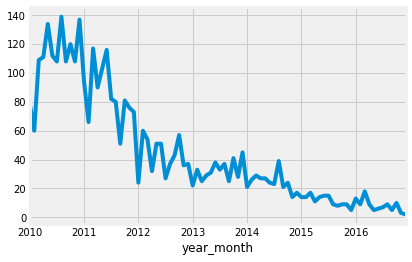

In [20]:
df_possibleprimary_tst['HARGA_B']['count'].plot()

In [21]:
df_possibleprimarySel = df_napic_master[(df_napic_master['PM_PERTAMA'] == 'Y') &
                                       (df_napic_master['STATE'] == 'Selangor') &
                                       (df_napic_master['PRO_TYPE'] == 'Condominium/Apartment')].copy()

In [22]:
df_possiblesecondarySel =df_napic_master[(df_napic_master['PM_PERTAMA'] == 'T') &
                                       (df_napic_master['STATE'] == 'Selangor') &
                                       (df_napic_master['PRO_TYPE'] == 'Condominium/Apartment')].copy()

In [23]:
df_possibleprimary_tsSel = df_possibleprimarySel.groupby('year_month')[columns_of_interest].agg(['mean', 'median','count'])
df_possiblesecond_tsSel = df_possiblesecondarySel.groupby('year_month')[columns_of_interest].agg(['mean', 'median','count'])

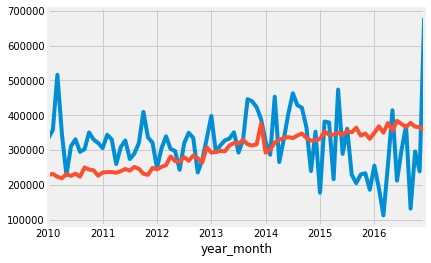

In [24]:
df_possibleprimary_tsSel['HARGA_B']['mean'].plot()
df_possiblesecond_tsSel['HARGA_B']['mean'].plot()

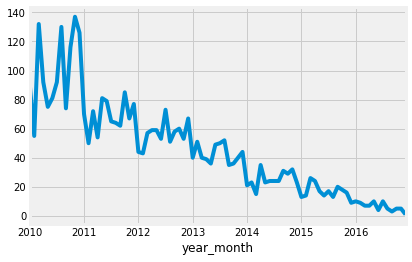

In [25]:
df_possibleprimary_tsSel['HARGA_B']['count'].plot()
# df_possiblesecond_tsSel['HARGA_B']['count'].plot()